<a href="https://colab.research.google.com/github/bharathts1507/TSAI-Assignments-EVA4/blob/master/TSAI_EVA4_S5_Model_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Method 2: Batch Normalization and Drop out applied to light model

#Target : 
- Lesser parameters around 10K
- Test Accuracy ~99%+ 
- ~15 Epochs 

#Results: 
- Parameters used : 10970
- Train Accuracy: 99.31%
- Test Accuracy : 98.84%

#Analysis - Observation :
- Overfitting observed
- Model is not stable as the test accuracy fluctuates at different epoch 

In [0]:
#Import necessary libraries
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
#Using data with normalized values and converting images into Tensor form
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])
#Download and setup train and test datasets
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)



In [6]:
#Keep seed constant to reproduce same results
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? False


In [7]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

# plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:55: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(0.0009)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([64, 1, 28, 28])
torch.Size([64])


In [0]:
#Create Architecture of model - layers, parameters and channels 

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 26, RF=3x3, step=1

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 24, RF=5x5, step=1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 22, RF=7x7, step=1

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 11, RF=7x7, step=2

        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 9, RF=11x11, step=2
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(20),
            nn.ReLU()
        ) # output_size = 7, RF=15, step=2

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(10),
            nn.ReLU()
        ) # output_size = 7, RF=15, step=2
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(7, 7), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1, RF=27, step=2

        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.dropout(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cpu
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200
      BatchNorm2d-13           [-1, 10, 11, 11]              20
             ReLU-14           [-1,

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
  
    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.06258587539196014 Batch_id=937 Accuracy=94.76: 100%|██████████| 938/938 [01:50<00:00,  8.53it/s]
Loss=0.112178735435009 Batch_id=0 Accuracy=96.88:   0%|          | 1/938 [00:00<01:52,  8.31it/s]


Test set: Average loss: 0.0618, Accuracy: 9818/10000 (98.18%)

EPOCH: 1


Loss=0.04100436344742775 Batch_id=937 Accuracy=98.03: 100%|██████████| 938/938 [01:50<00:00,  8.52it/s]
Loss=0.035590216517448425 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:59,  7.86it/s]


Test set: Average loss: 0.0423, Accuracy: 9866/10000 (98.66%)

EPOCH: 2


Loss=0.057250332087278366 Batch_id=937 Accuracy=98.45: 100%|██████████| 938/938 [01:53<00:00,  8.27it/s]
Loss=0.02468273416161537 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<02:01,  7.70it/s]


Test set: Average loss: 0.0640, Accuracy: 9790/10000 (97.90%)

EPOCH: 3


Loss=0.006530409213155508 Batch_id=937 Accuracy=98.71: 100%|██████████| 938/938 [01:55<00:00,  8.10it/s]
Loss=0.0030658987816423178 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:55,  8.09it/s]


Test set: Average loss: 0.0310, Accuracy: 9898/10000 (98.98%)

EPOCH: 4


Loss=0.0030370191670954227 Batch_id=937 Accuracy=98.73: 100%|██████████| 938/938 [01:53<00:00,  8.26it/s]
Loss=0.017388910055160522 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:56,  8.05it/s]


Test set: Average loss: 0.0437, Accuracy: 9862/10000 (98.62%)

EPOCH: 5


Loss=0.05621122941374779 Batch_id=937 Accuracy=98.89: 100%|██████████| 938/938 [01:54<00:00,  8.23it/s]
Loss=0.04102860391139984 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:51,  8.40it/s]


Test set: Average loss: 0.0309, Accuracy: 9900/10000 (99.00%)

EPOCH: 6


Loss=0.006360324565321207 Batch_id=937 Accuracy=98.98: 100%|██████████| 938/938 [01:53<00:00,  8.29it/s]
Loss=0.022942576557397842 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:56,  8.03it/s]


Test set: Average loss: 0.0305, Accuracy: 9893/10000 (98.93%)

EPOCH: 7


Loss=0.03903331980109215 Batch_id=937 Accuracy=99.05: 100%|██████████| 938/938 [01:52<00:00,  8.34it/s]
Loss=0.004691713489592075 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:52,  8.30it/s]


Test set: Average loss: 0.0305, Accuracy: 9892/10000 (98.92%)

EPOCH: 8


Loss=0.14102458953857422 Batch_id=937 Accuracy=99.10: 100%|██████████| 938/938 [01:52<00:00,  8.36it/s]
Loss=0.0043732482008636 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:56,  8.04it/s]


Test set: Average loss: 0.0385, Accuracy: 9876/10000 (98.76%)

EPOCH: 9


Loss=0.07336719334125519 Batch_id=937 Accuracy=99.13: 100%|██████████| 938/938 [01:50<00:00,  8.49it/s]
Loss=0.007897553965449333 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:55,  8.11it/s]


Test set: Average loss: 0.0379, Accuracy: 9872/10000 (98.72%)

EPOCH: 10


Loss=0.013632278889417648 Batch_id=937 Accuracy=99.20: 100%|██████████| 938/938 [01:49<00:00,  8.54it/s]
Loss=0.04242002218961716 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:45,  8.85it/s]


Test set: Average loss: 0.0272, Accuracy: 9897/10000 (98.97%)

EPOCH: 11


Loss=0.019196024164557457 Batch_id=937 Accuracy=99.22: 100%|██████████| 938/938 [01:49<00:00,  8.53it/s]
Loss=0.0038914333563297987 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:55,  8.13it/s]


Test set: Average loss: 0.0325, Accuracy: 9892/10000 (98.92%)

EPOCH: 12


Loss=0.0038338336162269115 Batch_id=937 Accuracy=99.23: 100%|██████████| 938/938 [01:50<00:00,  8.50it/s]
Loss=0.0008772393339313567 Batch_id=0 Accuracy=100.00:   0%|          | 1/938 [00:00<01:51,  8.38it/s]


Test set: Average loss: 0.0315, Accuracy: 9900/10000 (99.00%)

EPOCH: 13


Loss=0.019702449440956116 Batch_id=937 Accuracy=99.34: 100%|██████████| 938/938 [01:49<00:00,  8.59it/s]
Loss=0.014784515835344791 Batch_id=0 Accuracy=98.44:   0%|          | 1/938 [00:00<01:50,  8.47it/s]


Test set: Average loss: 0.0298, Accuracy: 9890/10000 (98.90%)

EPOCH: 14


Loss=0.0009158403845503926 Batch_id=937 Accuracy=99.31: 100%|██████████| 938/938 [01:49<00:00,  8.60it/s]



Test set: Average loss: 0.0342, Accuracy: 9884/10000 (98.84%)



Text(0.5, 1.0, 'Test Accuracy')

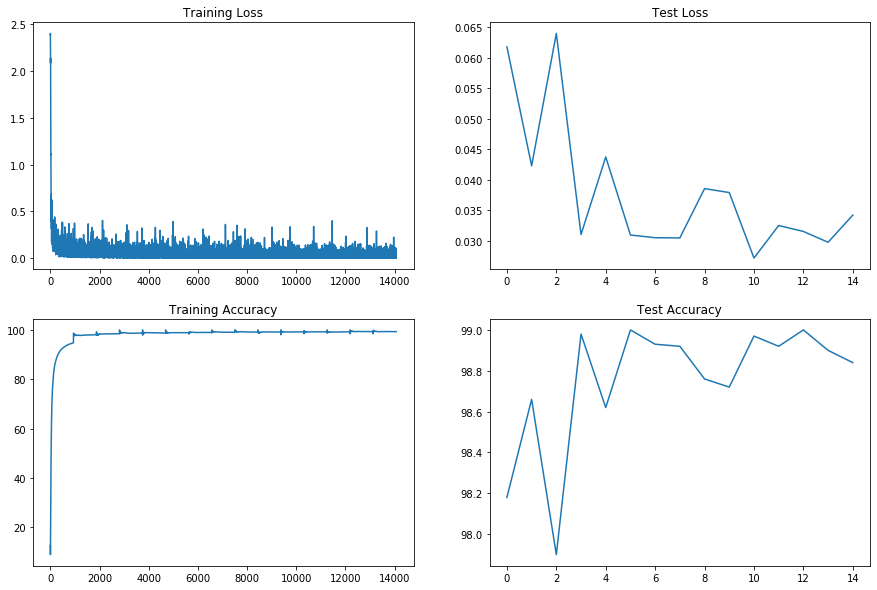

In [12]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")